<h1>Papila dataset - Glaucoma classification</h1><hr>

### Import neccesary libraries

In [4]:
%cd /content/drive/My Drive/papila_img/

/content/drive/My Drive/papila_img


In [169]:
#   basic packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random

#   img packages

from PIL import Image
from skimage.transform import resize

#   ml packages

from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split

#   deep learning packages

import tensorflow as tf
from keras.metrics import Precision
from tensorflow import keras
from keras.layers import Dense, Flatten,Conv2D,Dropout,AveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#   mlops packages

# import mlflow
# import mlflow.pyfunc

# %%

# fixed variables, setup seeds and filter warnings messages

ROOT_DIR = '../'

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

warnings.filterwarnings('ignore')

### Define main functions, extract from paper HelpCode section

In [2]:
def _fix_df(df):
    """Prepare the Data Frame to be readable
    """
    df_new = df.drop(['ID'], axis=0)
    df_new.columns = df_new.iloc[0,:]
    df_new.drop([np.nan], axis=0, inplace=True)
    df_new.columns.name = 'ID'
    return df_new

def read_clinical_data(abs_path='../'):
    """Return excel data as pandas Data Frame
    """
    df_od = pd.read_excel(abs_path + 'ClinicalData/patient_data_od.xlsx', index_col=[0])
    df_os = pd.read_excel(abs_path + 'ClinicalData/patient_data_os.xlsx', index_col=[0])
    return _fix_df(df=df_od), _fix_df(df=df_os)

### Read clinical data

In [6]:
df_od, df_os = read_clinical_data('./')

### Feature engineering

*   OD -> Oculus Dexter(right eye)
*   OS -> Oculus Sinister (left eye)



In [8]:
def create_token_id(df_sample,direction = 'OS'):
    # reminder that: OD -> Oculus Dexter(right eye) and OS -> Oculus Sinister (left eye)

    df_sample = df_sample.copy()
    df_sample = df_sample.reset_index().rename({'index':'token_id'},axis = 1)

    df_sample['token_id'] = df_sample['token_id'].apply(lambda x: 'RET' + x.replace('#','').strip() + direction+'.jpg')
    df_sample['eye_side'] = direction

    return df_sample

### Join both eyes set

In [9]:
df_test_os = create_token_id(df_os,'OS')
df_test_od = create_token_id(df_od,'OD')

df_join_data = pd.concat([df_test_os,df_test_od])

In [11]:
df_join_data.sample(10)

ID,token_id,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD,eye_side
72,RET105OS.jpg,78,0,1,1,-1.5,80,1,NaN,20,563,25.43,-6.75,OS
0,RET002OD.jpg,47,0,2,0.75,-1.75,90,0,21,NaN,586,23.64,-0.07,OD
193,RET239OD.jpg,47,1,0,0.5,-0.25,35,0,14,NaN,558,22.33,NaN,OD
79,RET116OS.jpg,68,1,1,3.75,-1.5,90,1,NaN,17,NaN,21.05,-10.36,OS
158,RET203OD.jpg,68,0,0,2.25,-2,85,0,19,NaN,571,23.83,NaN,OD
235,RET285OD.jpg,58,1,0,1.5,-0.5,105,0,14,NaN,482,22.73,NaN,OD
199,RET245OS.jpg,49,1,0,1,-0.75,110,0,16,NaN,493,22.63,NaN,OS
63,RET090OS.jpg,72,0,1,2.25,-2.25,90,1,NaN,17,572,24.07,-1.4,OS
84,RET123OS.jpg,74,0,1,0.25,-0.75,125,1,NaN,24,595,24.25,-22.69,OS
63,RET090OD.jpg,72,0,1,2,-1.5,95,1,NaN,28,573,23.87,-4.31,OD


### Class availabes

*   0, healthy
*   1, glaucoma
*   2, suspicious






In [12]:
# based on the test #2 from paper experiments, remove suspicious class (2)

df_join_data['Diagnosis'] = df_join_data['Diagnosis'].replace(2,0)

### Get X and y datasets

In [75]:
# def x_and_y_dataset(lower_index,upper_index,eye_class = 'both'):
def x_dataset(df_sample):
    df_sample = df_sample.copy()
    # if eye_class == 'both':
    #     df_sample = df_join_data.copy() # in this fuction, df_join_data is a global variable
    # else:
    #     df_sample = df_join_data[df_join_data.eye_side == eye_class]

    list_to_tensor,list_not_available = [],[]

    # for i, row in df_sample.iloc[lower_index:upper_index,:].iterrows():
    for i, row in df_sample.iterrows():
        try:
            # resize img to 224 x 224 because, RESNET50 was trained with this configuration
            resize_sample = resize(np.array(Image.open("FundusImages/" + row['token_id'])), (224, 224))
            list_to_tensor.append(resize_sample)
        except:
            print(f'the sample {row["token_id"]} is not available')
            list_not_available.append(row["token_id"])

    X_set = np.array(list_to_tensor)
    # y_set = df_join_data.iloc[lower_index:upper_index,:].Diagnosis
    return X_set
    # return X_set,y_set

# plot eyes sample

def visualize_four_samples(X_set):
    _, ax = plt.subplots(2, 2, figsize=(10, 10))
    index = 0

    for i in range(2):
        for j in range(2):
            cell = ax[i][j]
            cell.set_xticks([])
            cell.set_yticks([])
            cell.grid(False)
            cell.imshow(X_set[index], cmap='gray')
            index += 1

    plt.show()

### Balance dataset

In [48]:
df_join_data.Diagnosis.value_counts(normalize = True)

0    0.821721
1    0.178279
Name: Diagnosis, dtype: float64

In [49]:
df_join_data.Diagnosis.value_counts(normalize = False)

0    401
1     87
Name: Diagnosis, dtype: int64

In [56]:
df_healty_sample = df_join_data[df_join_data.Diagnosis == 0].sample(87, random_state = 42)

In [53]:
df_glaucoma = df_join_data[df_join_data.Diagnosis == 1]

In [59]:
df_balanced_set = pd.concat([df_healty_sample, df_glaucoma])

In [61]:
df_balanced_set.head()

ID,token_id,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD,eye_side
125,RET168OD.jpg,71,0,0,0.25,-1.5,87,1,14,NaN,531,23.78,NaN,OD
121,RET163OD.jpg,61,1,0,1.75,-0.75,13,1,18,NaN,602,22.59,NaN,OD
71,RET104OS.jpg,57,0,0,1,-0.5,175,1,16,15,493,23.58,0.22,OS
27,RET034OD.jpg,57,1,0,0.75,-0.5,80,1,18,NaN,525,23.87,NaN,OD
137,RET181OS.jpg,52,0,0,0,-0.5,83,0,18,NaN,541,23.85,NaN,OS


In [63]:
df_balanced_set.Diagnosis.value_counts()

0    87
1    87
Name: Diagnosis, dtype: int64

In [64]:
X = df_balanced_set.drop('Diagnosis',axis = 1)
y = df_balanced_set['Diagnosis']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
y_train.mean()

0.5035971223021583

In [69]:
y_test.mean()

0.4857142857142857

### Generate X train and X test sets

In [76]:
X_train_tensor = x_dataset(X_train)
X_test_tensor = x_dataset(X_test)

- Train img

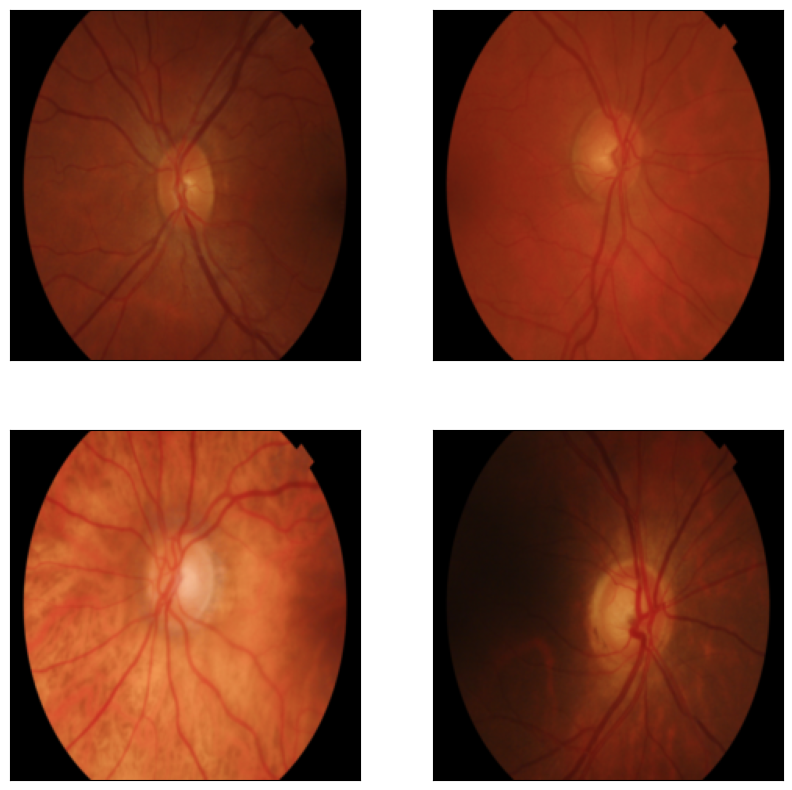

In [79]:
visualize_four_samples(X_train_tensor)

- Test img

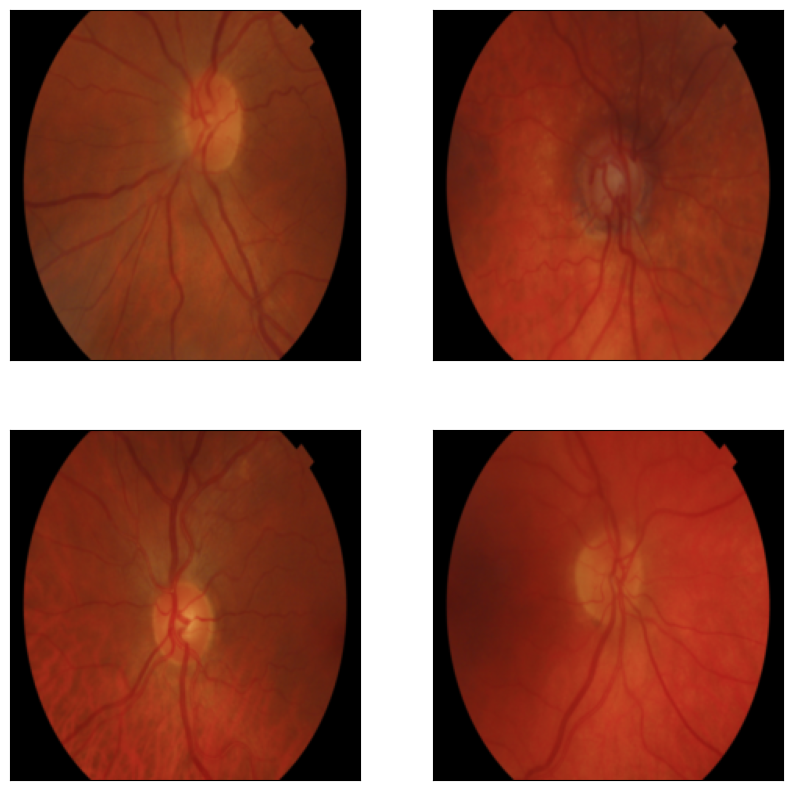

In [80]:
visualize_four_samples(X_test_tensor)

## Simple CNN

In [82]:
#   ANN - architecture

model_simple = keras.Sequential([
     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
     Conv2D(64, (3, 3), activation='relu', strides=(2, 2)),
     Conv2D(128, (3, 3), activation='relu'),
     Dropout(0.5),
     Flatten(),
     # Fully connected layers
     Dense(64, activation='relu'),
     Dense(64, activation='relu'),
     Dense(1, activation='sigmoid')
])

#   compile settings

model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

#   train model

model_simple.fit(X_train_tensor, y_train, epochs=50)


Epoch 1/50
5/5 [==============================] - 53s 10s/step - loss: 0.8264 - precision_1: 0.5333
Epoch 2/50
5/5 [==============================] - 42s 8s/step - loss: 0.6955 - precision_1: 0.5076
Epoch 3/50
5/5 [==============================] - 44s 9s/step - loss: 0.6845 - precision_1: 0.9167
Epoch 4/50
5/5 [==============================] - 42s 8s/step - loss: 0.6761 - precision_1: 0.5377
Epoch 5/50
5/5 [==============================] - 42s 8s/step - loss: 0.6512 - precision_1: 0.6197
Epoch 6/50
5/5 [==============================] - 44s 9s/step - loss: 0.6545 - precision_1: 0.6825
Epoch 7/50
5/5 [==============================] - 40s 8s/step - loss: 0.5678 - precision_1: 0.7179
Epoch 8/50
5/5 [==============================] - 42s 8s/step - loss: 0.6433 - precision_1: 0.6875
Epoch 9/50
5/5 [==============================] - 44s 9s/step - loss: 0.5576 - precision_1: 0.6263
Epoch 10/50
5/5 [==============================] - 42s 8s/step - loss: 0.5331 - precision_1: 0.8000
Epoch 11

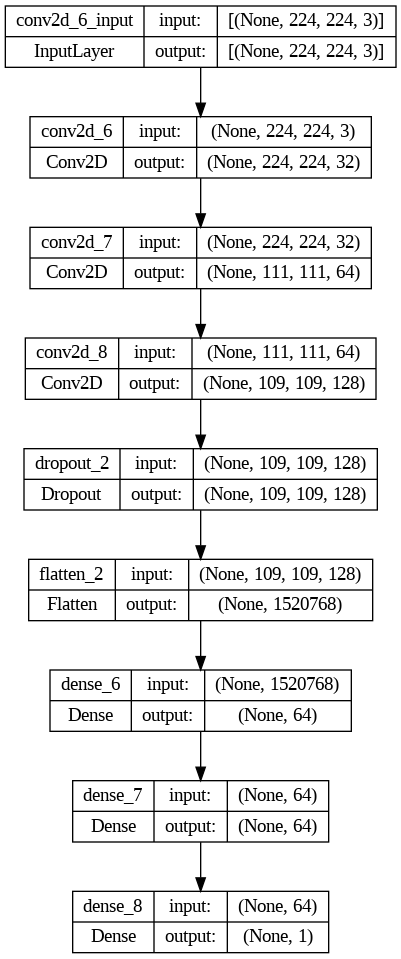

In [120]:
plot_model(model_simple, show_shapes=True)

In [84]:
model_simple.evaluate(X_train_tensor,y_train)

5/5 [==============================] - 16s 3s/step - loss: 0.0158 - precision_1: 1.0000


[0.01575533114373684, 1.0]

In [85]:
model_simple.evaluate(X_test_tensor,y_test)

2/2 [==============================] - 3s 207ms/step - loss: 1.3348 - precision_1: 0.8462


[1.3348164558410645, 0.8461538553237915]

In [86]:
y_pred_prob_ann_cnn = model_simple.predict(X_test_tensor)

2/2 [==============================] - 5s 202ms/step


In [87]:
y_pred_ann_cnn = (y_pred_prob_ann_cnn.flatten() >0.5)+0

In [89]:
accuracy_score(y_test,y_pred_ann_cnn)

0.7714285714285715

In [90]:
precision_score(y_test,y_pred_ann_cnn)

0.8461538461538461

In [91]:
recall_score(y_test,y_pred_ann_cnn)

0.6470588235294118

In [94]:
print(classification_report(y_test,y_pred_ann_cnn))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.85      0.65      0.73        17

    accuracy                           0.77        35
   macro avg       0.79      0.77      0.77        35
weighted avg       0.79      0.77      0.77        35



In [96]:
confusion_matrix(y_test, y_pred_ann_cnn)

array([[16,  2],
       [ 6, 11]])

### Precision vs Recall - CNN


In [98]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_ann_cnn)

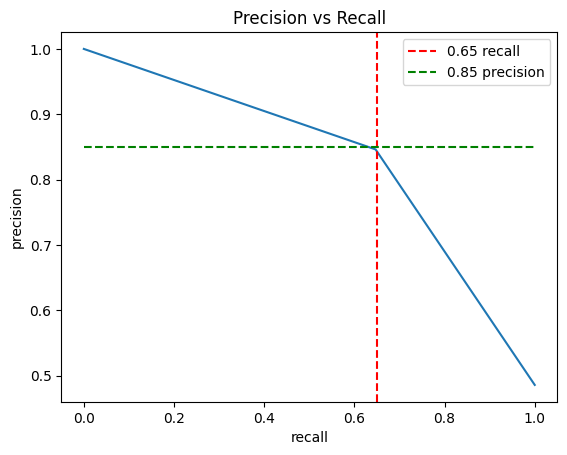

In [113]:
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision vs Recall')
plt.axvline(x = 0.65, linestyle = '--', color = 'r', label = '0.65 recall')
plt.hlines(y = 0.85, xmin = 0, xmax = 1, linestyle = '--',label = '0.85 precision', color = 'g')
plt.legend()
plt.show()

### ROC curve CNN

In [162]:
fpr, tpr, _ = roc_curve(y_test.values, y_pred_ann_cnn)

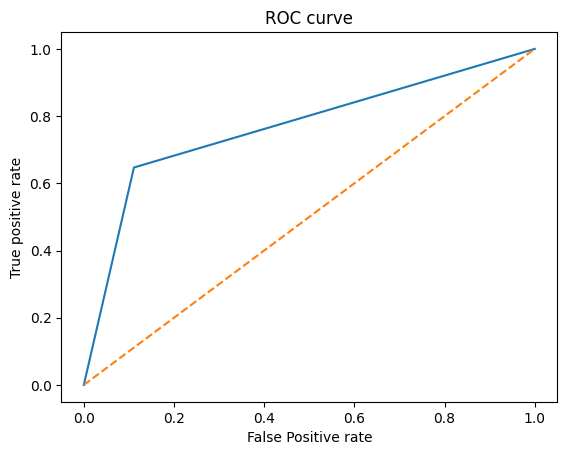

In [167]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle = '--')
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

### Save Simple CNN

In [ ]:
model_simple.save('model_simple.h5')

## Lenet ANN architecture

In [170]:
model_lenet = keras.Sequential([
     Conv2D(6, (5, 5), activation='tanh',padding='same',strides=(1, 1), input_shape=(224, 224, 3)),
     AveragePooling2D(strides = (2,2)),
     Conv2D(16, kernel_size = (5, 5), activation='tanh', strides=(1, 1)),
     AveragePooling2D(strides = (2,2)),
     Conv2D(120, kernel_size = (5,5), activation='tanh', strides=(1, 1)),
     Flatten(),
    #  Dense(120, activation='relu'),
     Dense(84, activation='tanh'),
     Dense(2, activation='softmax') # Capa de salida
])

In [131]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [151]:
model_lenet.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[Precision()])

In [ ]:
model_lenet.evaluate(X_train,y_train)

5/5 [==============================] - 0s 21ms/step - loss: 0.6070 - accuracy: 0.7067


[0.6069968938827515, 0.7066666483879089]

In [ ]:
model_lenet.evaluate(X_test,y_test)

2/2 [==============================] - 0s 20ms/step - loss: 0.3294 - accuracy: 0.9800


[0.3293933868408203, 0.9800000190734863]

## Resnet50

In [ ]:
base_model_resnet50 = ResNet50(weights ='imagenet', include_top = False)
x = base_model_resnet50.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

resnet50_model = Model(inputs=base_model_resnet50.input , outputs=preds)

for layer in base_model_resnet50.layers:
    layer.trainable=False

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [ ]:
resnet50_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
5/5 [==============================] - 6s 305ms/step - loss: 0.7046 - accuracy: 0.6000
Epoch 2/100
5/5 [==============================] - 0s 89ms/step - loss: 0.6258 - accuracy: 0.7000
Epoch 3/100
5/5 [==============================] - 0s 90ms/step - loss: 0.6110 - accuracy: 0.7067
Epoch 4/100
5/5 [==============================] - 0s 90ms/step - loss: 0.6302 - accuracy: 0.7067
Epoch 5/100
5/5 [==============================] - 0s 90ms/step - loss: 0.6011 - accuracy: 0.7067
Epoch 6/100
5/5 [==============================] - 0s 89ms/step - loss: 0.6371 - accuracy: 0.7067
Epoch 7/100
5/5 [==============================] - 0s 93ms/step - loss: 0.6276 - accuracy: 0.6933
Epoch 8/100
5/5 [==============================] - 0s 90ms/step - loss: 0.6143 - accuracy: 0.7067
Epoch 9/100
5/5 [==============================] - 0s 90ms/step - loss: 0.6248 - accuracy: 0.6733
Epoch 10/100
5/5 [==============================] - 0s 90ms/step - loss: 0.6110 - accuracy: 0.7067
Epoch 11/100
5/5 [

In [ ]:
resnet50_model.evaluate(X_train,y_train)

5/5 [==============================] - 1s 92ms/step - loss: 0.6060 - accuracy: 0.7067


[0.6060414910316467, 0.7066666483879089]

In [ ]:
resnet50_model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 82ms/step - loss: 0.3922 - accuracy: 0.9800


[0.39215072989463806, 0.9800000190734863]